In [1]:
#!pip install wget
#!pip install suntime
#!pip install s3fs
#!pip install pyresample
#!pip install satpy
#!pip install pyspectral

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/reykoki/Smoke_Learning_Notebook/blob/main/Learning_Notebook.ipynb)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
from glob import glob
import os
import time
from datetime import datetime
import wget
os.getcwd()
from IPython.display import Image, display
import sys
sys.path.insert(1, './scripts')

# Develop a Machine Learning Ready Dataset from GOES Satellite Imagery
## 1. Data
We will take data from the GOES-EAST Advanced Baseline Imager (ABI) and generate a datasample that is geographically localized for a given latitude and longitude.
#### Data Objectives
1. Given a date and time and location, download the corresponding [GOES satellite imagery from AWS](https://registry.opendata.aws/noaa-goes/)
2. Process and visualize a True Color composite for the Continental US (CONUS)
3. Geographically localize the GOES satellite imagery

### 1.2 GOES Satellite Imagery

For a comprehensive technical guide to GOES satellites and their instruments, refer to the [GOES-R Series Data Book](https://www.goes-r.gov/downloads/resources/documents/GOES-RSeriesDataBook.pdf).

The GOES series Advanced Baseline Imager provides data at 16 channels that cover visible (C01-C02), near-IR (C03-C06) and IR (C07-C16) bands. 


| Band | Descirption | Center Wavelength ($\mu$m) | Spatial Resolution (km) |
| :-: | :-: | :-: | :-: |
| [C01](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band01.pdf) | Blue visible | 0.47 | 1 |
| [C02](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band02.pdf) | Red visible | 0.64 | 0.5 |
| [C03](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band03.pdf) | Veggie near infrared | 0.865 | 1 |
| [C04](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band04.pdf) | Cirrus | 1.378 | 2 |
| [C05](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band05.pdf) | Snow/Ice | 1.61 | 1 |
| [C06](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band06.pdf) | Cloud particle | 2.24 | 2 |
| [C07](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band07.pdf) | Shortwave IR | 3.9 | 2 |
| [C08](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band08.pdf) | upper-level water vapor | 6.2 | 2 |
| [C09](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band09.pdf) | mid-level water vapor | 6.9 | 2 |
| [C10](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band10.pdf) | lower-level water vapor | 7.3 | 2 |
| [C11](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band11.pdf) | IR cloud phase | 8.5 | 2 |
| [C12](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band12.pdf) | ozone | 9.6 | 2 |
| [C13](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band13.pdf) | clean longwave IR | 10.35 | 2 |
| [C14](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band14.pdf) | longwave IR | 11.2 | 2 |
| [C15](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band15.pdf) | dirty longwave IR | 12.3 | 2 |
| [C16](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band16.pdf) | CO$_2$ | 13.3 | 2 |

To create a true color image, we use the following bands from the Advanced Baseline Imager Level 1b CONUS (ABI-L1b-RadC) product.

A new ABI-L1b-RadC data file is produced every 5 minutes from both GOES-East and GOES-West and provided in netCDF4 format. 

In [ ]:
curr_goes = "./figures/GOES16-CONUS-GEOCOLOR-625x375.gif"
os.system("wget -qO {} https://cdn.star.nesdis.noaa.gov/GOES16/ABI/CONUS/GEOCOLOR/GOES16-CONUS-GEOCOLOR-625x375.gif".format(curr_goes))
display(Image(filename=curr_goes))

### 1.3 True Color GOES Imagery

For this part of the tutorial, we will visualize GOES data using the first three bands to create a true color image.

We use the [satpy](https://satpy.readthedocs.io/en/latest/) library to read and augment our satellite data as seen in the image below.

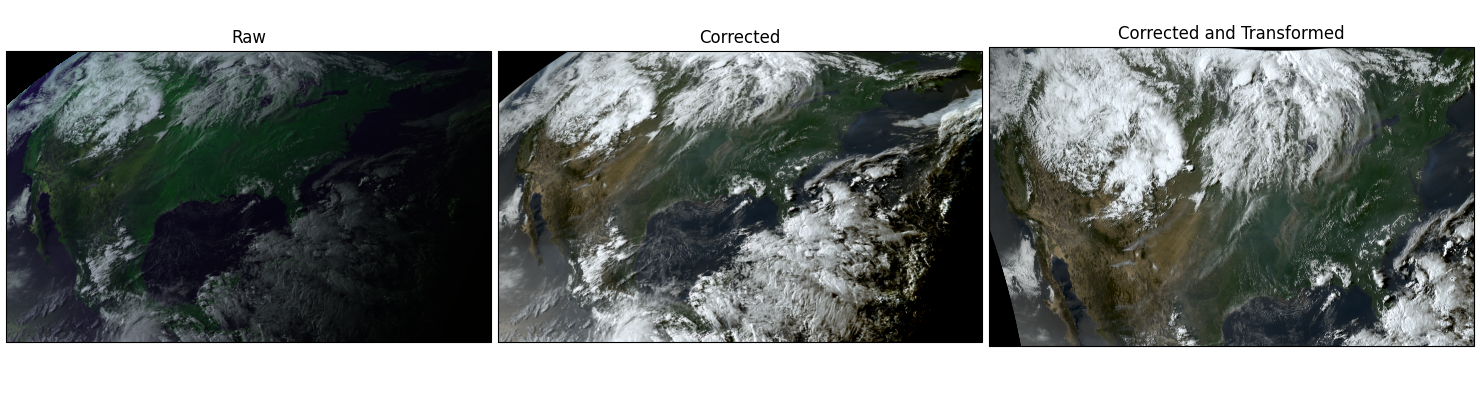

In [3]:
display(Image(filename="figures/processing.png"))

We apply a composite of corrections based on algorithms introduced in this [article](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018EA000379) developed specifically for GOES imagery.

The corrections applied:
- **true color** - correction to make the image look closer to what our eyes would see (it uses a combination of C01, C02 and C03 to make an approximation to green).
- **solar zenith angle** - correction for atmopsheric interactions with the light due to the solar zenith angle.
- **rayleigh scattering** - correction for how different wavelengths scatter off of particular atmposheric particles.

Additionally, we transform the image onto a [Lambert conformal conic projection](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) in order to reduce the distortion created by the [geostationary azimuthal projection](https://proj.org/en/9.2/operations/projections/geos.html). Correcting distortortions 

Use the format YYYY/MM/DD HH:MM to specify the time you'd like to grab imagery for

In [4]:
dt_str = '2023/09/24 21:00'
lat = '40.0'
lon = '-105.27'

from grab_goes import download_goes
sat_fns = download_goes(dt_str)

for the datetime 2023-09-24 21:00:00+00:00:
sunrise is at: 2023-09-24 14:09:00+00:00
sunset is at: 2023-09-24 22:38:00+00:00
OR_ABI-L1b-RadC-M6C01_G16_s20232672101174_e20232672103547_c20232672103581.nc already exists
OR_ABI-L1b-RadC-M6C02_G16_s20232672101174_e20232672103547_c20232672103575.nc already exists
OR_ABI-L1b-RadC-M6C03_G16_s20232672101174_e20232672103547_c20232672103595.nc already exists
OR_ABI-L1b-RadC-M6C04_G16_s20232672101174_e20232672103547_c20232672103584.nc already exists
OR_ABI-L1b-RadC-M6C05_G16_s20232672101174_e20232672103547_c20232672103592.nc already exists
OR_ABI-L1b-RadC-M6C06_G16_s20232672101174_e20232672103552_c20232672103587.nc already exists
OR_ABI-L1b-RadC-M6C07_G16_s20232672101174_e20232672103559_c20232672103598.nc already exists
OR_ABI-L1b-RadC-M6C08_G16_s20232672101174_e20232672103547_c20232672104027.nc already exists
OR_ABI-L1b-RadC-M6C09_G16_s20232672101174_e20232672103552_c20232672104023.nc already exists
OR_ABI-L1b-RadC-M6C10_G16_s20232672101174_e2023

### 1.4 True Color Composite GOES Satellite Imagery

#### ***NOTE:*** running this will take a few minutes

['./data/goes/OR_ABI-L1b-RadC-M6C01_G16_s20232672101174_e20232672103547_c20232672103581.nc', './data/goes/OR_ABI-L1b-RadC-M6C03_G16_s20232672101174_e20232672103547_c20232672103595.nc', './data/goes/OR_ABI-L1b-RadC-M6C02_G16_s20232672101174_e20232672103547_c20232672103575.nc']


The following datasets were not created and may require resampling to be generated: DataID(name='cimss_true_color_sunz_rayleigh')
Rounding shape to (967, 1567) and resolution from (3000.0, 3000.0) meters to (2999.3618379068284, 2998.965873836608) meters
/home/rey/projects/smoke/geopy/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
/home/rey/projects/smoke/geopy/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))
/home/rey/projects/smoke/geopy/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
/home/rey/projects/smoke/geopy/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


start of satellite scan:  2023-09-24 21:01:17.400000
end of satellite scan:  2023-09-24 21:03:54.700000


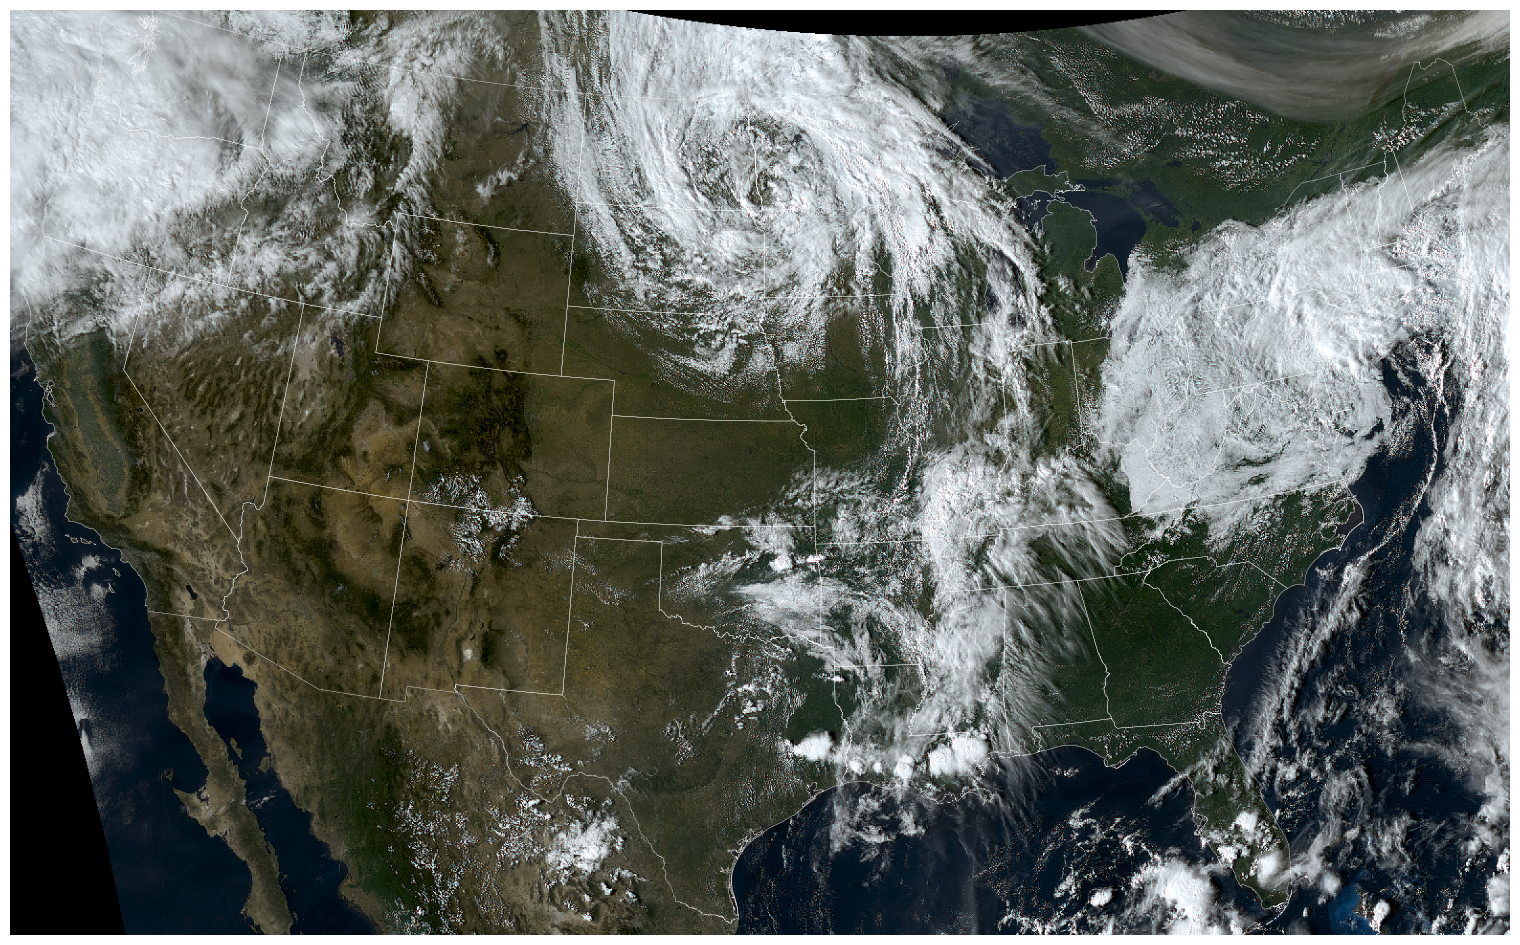

In [5]:
from plot_conus import plot_data # code located in /scripts/plot_conus.py
scn = plot_data(dt_str)

## Subsample the Image

At full resolution, the 3-channel CONUS satellite imagery contains 180 million pixels. With an increase in the number of pixels, there is a increase in the computational cost to run the machine learning model. For efficiency, we will work with images sized down to ~200,000 pixels but still cover 250 km$^2$.

### Raw Band Imagery

In [6]:
from create_data import create_composite, create_raw
from plot_tifs import plot_all_bands, plot_composite

In [7]:
fn_head, scn = create_raw(sat_fns, lat, lon)

In [8]:
from scipy.ndimage import interpolation

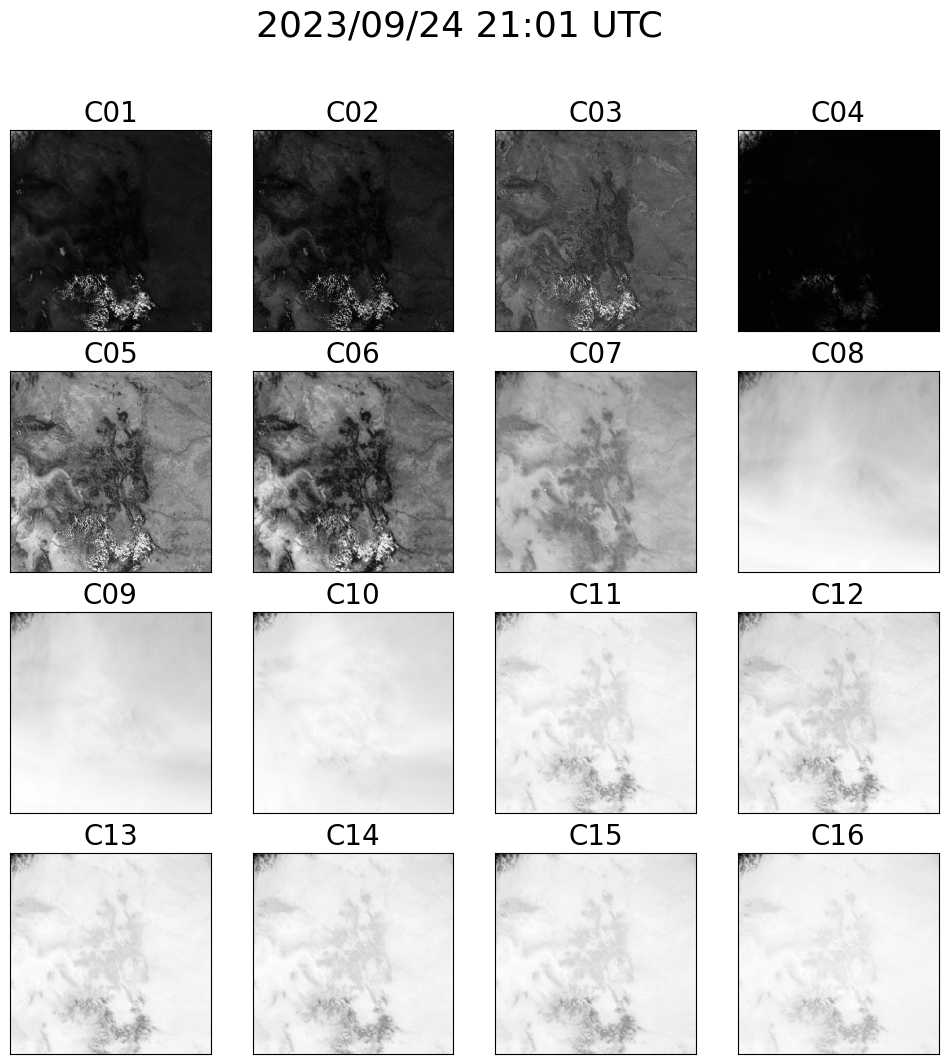

In [9]:
plot_all_bands(fn_head)

### Composites

In [14]:
composites = ['cimss_true_color_sunz_rayleigh', 'true_color_raw', 'true_color','natural_color']

In [15]:
fn_head, scn = create_composite(sat_fns, lat, lon, composites=composites)

2023/09/24 21:01 UTC


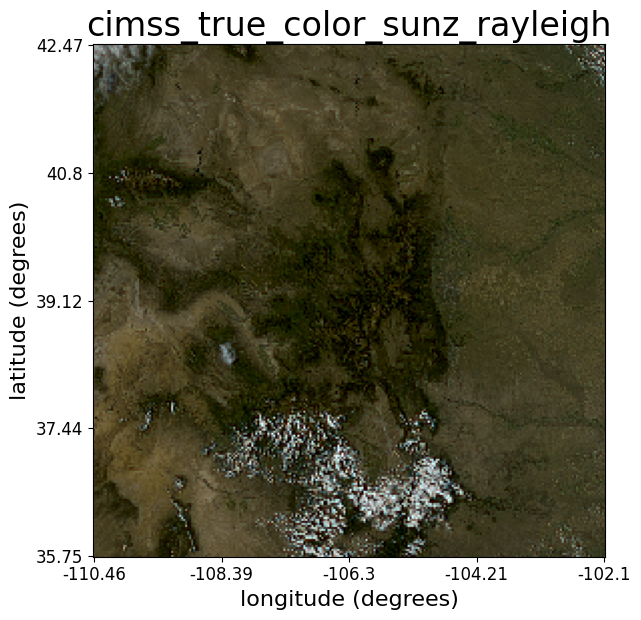

2023/09/24 21:01 UTC


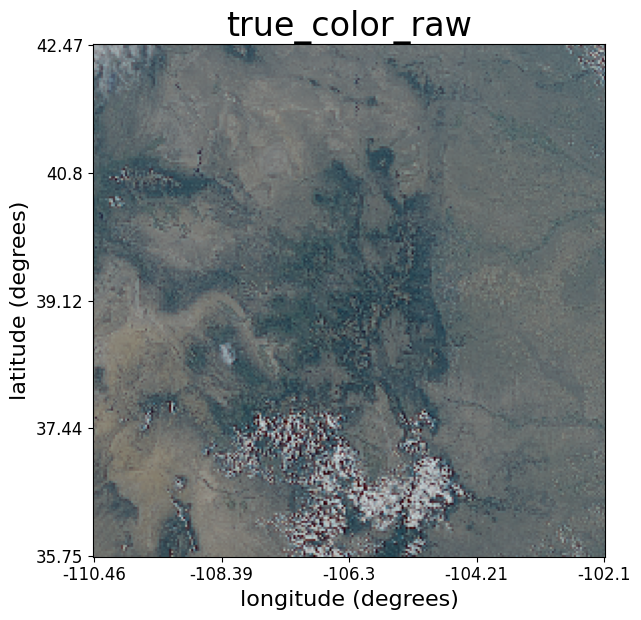

2023/09/24 21:01 UTC


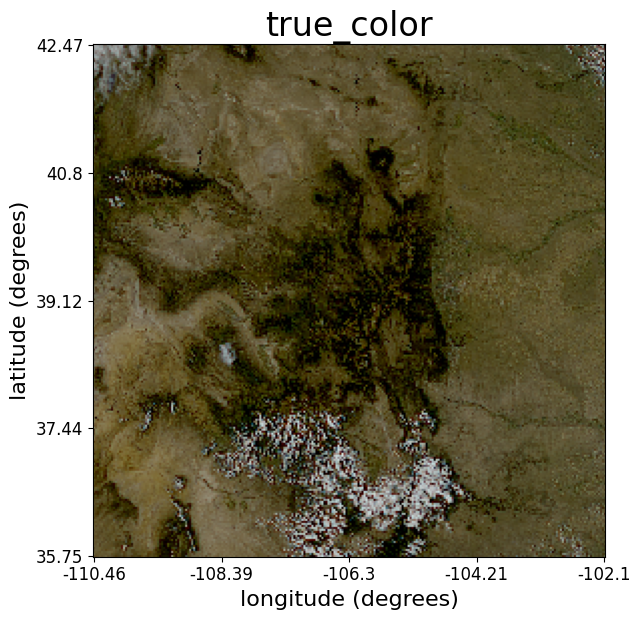

2023/09/24 21:01 UTC


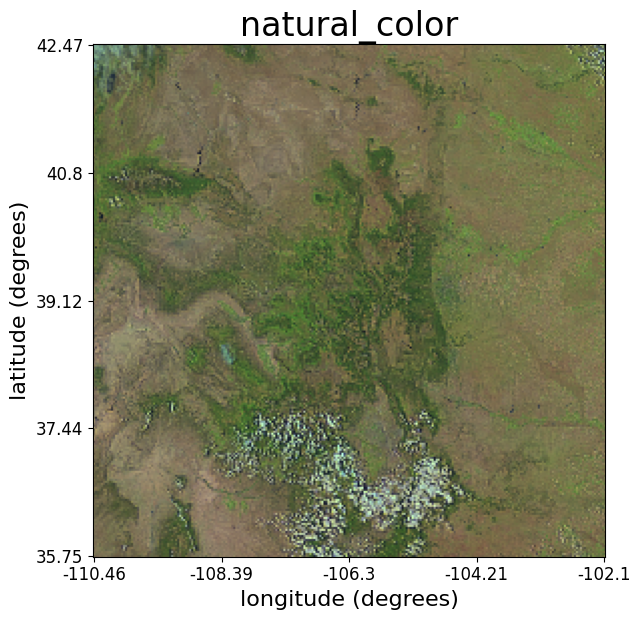

In [16]:
for composite in composites:
    plot_composite(composite, fn_head)